In [0]:
# https://github.com/suchartee/topic_modeling

# Libraries (RUN THIS)

In [1]:
import pandas as pd
import re
import requests
import string
import time
import sys
from bs4 import BeautifulSoup
# !pip install nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
# !pip install gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2019)
from gensim import corpora, models
from pprint import pprint
# !pip install pyldavis
import pyLDAvis
import pyLDAvis.gensim
import warnings
warnings.filterwarnings('ignore')
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
%matplotlib inline
# !pip install xlrd
import xlrd
import os
from nltk.tag import pos_tag
import os
import math
import numpy as np 
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet as wn
from itertools import chain
import collections
import operator
from operator import itemgetter
import numpy
# !pip install openpyxl
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Wagonnn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Wagonnn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Retrieve cleaned dataframe (before lemma and stem)

In [2]:
# # google colab
# # retrieve from google drive
# # Code to read csv file into Colaboratory:
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# # Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# id_ = '18uG3Xs-D0nHbykDFK_lYepCP90XAlG5q' # sharable link
# downloaded = drive.CreateFile({'id':id_}) 
# downloaded.GetContentFile('df.csv')  
# df_2 = pd.read_csv('df.csv')
# # Dataset is now stored in a Pandas Dataframe
# df_2.head()

In [3]:
os.chdir(r'C:\Users\Wagonnn\Dropbox (CSU Fullerton)\CSUF\Graduate Project\topic_modeling\topic_modeling\data')

In [4]:
# df = pd.read_csv('df.csv')
df_2 = pd.read_csv('df_2.csv')
df_2.head()

,Unnamed: 0,transcript,category
0,0,sat at the kitchen table in an unfamiliar apar...,CRIME
1,1,the starts in and now it has an official song ...,ENTERTAINMENT
2,2,actually turned to matrimony for the year old ...,ENTERTAINMENT
3,3,calif and fellow better grow pair in battling ...,ENTERTAINMENT
4,4,unleashed her funny method of venting at on th...,ENTERTAINMENT


In [5]:
df_2.shape

(35056, 3)

In [6]:
df_2.category.value_counts()

POLITICS          13944
ENTERTAINMENT      4938
WORLD NEWS         1925
QUEER VOICES       1765
COMEDY             1662
THE WORLDPOST      1403
BLACK VOICES       1328
WOMEN              1166
MEDIA               889
SPORTS              792
WEIRD NEWS          737
CRIME               689
GREEN               609
ARTS & CULTURE      597
BUSINESS            553
RELIGION            447
LATINO VOICES       405
IMPACT              401
EDUCATION           259
TECH                209
SCIENCE             145
COLLEGE              65
GOOD NEWS            46
WORLDPOST            43
FIFTY                18
ARTS                 18
HEALTHY LIVING        3
Name: category, dtype: int64

# 2nd experiment, reduced dataset, Lemma
min 15, max 0.5, 10 topics

In [7]:
# slice data into half
size = int(df_2.shape[0]/2)
# new_df_2 = df_2[:size]
new_df_2 = df_2
transcript2 = df_2.transcript.to_list()

In [8]:
# get list of stop words provided by NLTK and Gensim
nltk_stop_words = list(stopwords.words('english'))
gensim_stop_words = list(gensim.parsing.preprocessing.STOPWORDS)
stop_words = list(set(nltk_stop_words) | set(gensim_stop_words))

def lemma_stem(text):
#   stemmer = PorterStemmer()
#   stemmer = SnowballStemmer("english")
#   return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
    return WordNetLemmatizer().lemmatize(text, pos='n')

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop_words:
            result.append(lemma_stem(token))
    return result

# lemma and remove stop words
preprocessed_transcript2_2 = new_df_2['transcript'].fillna('').astype(str).map(preprocess)

In [9]:
preprocessed_transcript2_2.head()

0    [sat, kitchen, table, unfamiliar, apartment, a...
1    [start, official, song, reggaeton, star, colla...
2    [actually, turned, matrimony, year, old, actor...
3    [calif, fellow, better, grow, pair, battling, ...
4    [unleashed, funny, method, venting, star, told...
Name: transcript, dtype: object

# Topic Coherence
Finding the optimal number of topics by topic coherence
1. C_v measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity
2. C_p is based on a sliding window, one-preceding segmentation of the top words and the confirmation measure of Fitelson’s coherence
3. C_uci measure is based on a sliding window and the pointwise mutual information (PMI) of all word pairs of the given top words
4. C_umass is based on document cooccurrence counts, a one-preceding segmentation and a logarithmic conditional probability as confirmation measure
5. C_npmi is an enhanced version of the C_uci coherence using the normalized pointwise mutual information (NPMI)
6. C_a is baseed on a context window, a pairwise comparison of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity

Intrinsic Measure
It is represented as UMass. It measures to compare a word only to the preceding and succeeding words respectively, so need ordered word set.It uses as pairwise score function which is the empirical conditional log-probability with smoothing count to avoid calculating the logarithm of zero.

Extrinsic Measure
It is represented as UCI. In UCI measure, every single word is paired with every other single word. The UCIcoherence uses pointwise mutual information (PMI).


Both Intrinsic and Extrinsic measure compute the coherence score c (sum of pairwise scores on the words w1, …, wn used to describe the topic)

- https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore

- https://www.aclweb.org/anthology/N10-1012.pdf


http://www.saf21.eu/wp-content/uploads/2017/09/5004a165.pdf
Measures such as the predictive likelihood of held-out
data [31] have been proposed to evaluate the quality of generated topics. However, such a measure correlates negatively
with human interpretability [32]

## 3rd experiment with bi gram
20 passes, 10 topics

In [10]:
# bigram
bigram = gensim.models.Phrases(preprocessed_transcript2_2, min_count=5, threshold=50) # higher threshold fewer phrases
bigram_list = []
for i in range(len(preprocessed_transcript2_2)):
    bigram_list.append(bigram[preprocessed_transcript2_2[i]])

In [11]:
# create dictionary of all words (bi gram)
dictionary2_bi = gensim.corpora.Dictionary(bigram_list)
print("Dictionary size before filtering: " + str(len(dictionary2_bi)))

dictionary2_bi.filter_extremes(no_below=15, no_above=0.5, keep_n=50000)
print("Dictionary size after filtering: " + str(len(dictionary2_bi)))

# bag of words
bow_corpus2_bi = [dictionary2_bi.doc2bow(doc) for doc in bigram_list]

# applying tfidf - corresponding to the arguments in filter_extremes()
tfidf2_bi = models.TfidfModel(bow_corpus2_bi)
corpus_tfidf2_bi = tfidf2_bi[bow_corpus2_bi]

Dictionary size before filtering: 75129
Dictionary size after filtering: 23056


In [12]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    umass_values = []
    uci_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, workers=3)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        umass = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        umass_values.append(umass.get_coherence())
        uci = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_uci')
        uci_values.append(uci.get_coherence())

    return model_list, coherence_values, umass_values, uci_values

In [13]:
model_list, coherence_values, umass_values, uci_values = compute_coherence_values(dictionary=dictionary2_bi, corpus=corpus_tfidf2_bi, texts=bigram_list, start=2, limit=11, step=1)

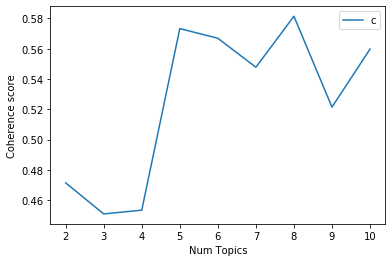

In [14]:
# Show c_v graph
limit=11; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [15]:
for i in range(len(model_list)):
  print("Model: " + str(model_list[i]))
  print("C_V: " + str(coherence_values[i]))
  print("Umass: " + str(umass_values[i]))
  print("Uci: " + str(uci_values[i]) + "\n")

Model: LdaModel(num_terms=23056, num_topics=2, decay=0.5, chunksize=2000)
C_V: 0.4713446473556666
Umass: -1.4183819228902652
Uci: 0.21618406153116027

Model: LdaModel(num_terms=23056, num_topics=3, decay=0.5, chunksize=2000)
C_V: 0.4508488934509472
Umass: -3.3233243856792014
Uci: -1.3664815715687937

Model: LdaModel(num_terms=23056, num_topics=4, decay=0.5, chunksize=2000)
C_V: 0.4533172665115083
Umass: -4.598530894167898
Uci: -1.1002047571588889

Model: LdaModel(num_terms=23056, num_topics=5, decay=0.5, chunksize=2000)
C_V: 0.5732646334046835
Umass: -1.703002615482583
Uci: 0.1555039214963939

Model: LdaModel(num_terms=23056, num_topics=6, decay=0.5, chunksize=2000)
C_V: 0.5668732285623702
Umass: -4.513388939018822
Uci: -0.5061813996480985

Model: LdaModel(num_terms=23056, num_topics=7, decay=0.5, chunksize=2000)
C_V: 0.5477477416113508
Umass: -3.9688181994945855
Uci: -0.2141872653088944

Model: LdaModel(num_terms=23056, num_topics=8, decay=0.5, chunksize=2000)
C_V: 0.5814191625139423


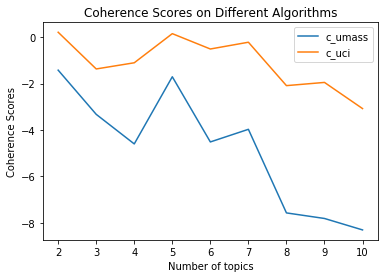

In [16]:
limit=11; start=2; step=1;
x = range(start, limit, step) # number of topics
y = [umass_values, uci_values]
plt.xlabel("Number of topics")
plt.ylabel("Coherence Scores")
plt.title("Coherence Scores on Different Algorithms")
label_name = ['c_umass', 'c_uci']
count = 0
for line in y:
  plt.plot(x, line, label = label_name[count])
  count += 1
# for i in range(len(y[0])):
#     plt.plot(x,[pt[i] for pt in y],label = 'id %s'%i)
plt.legend(loc='best')
plt.show()

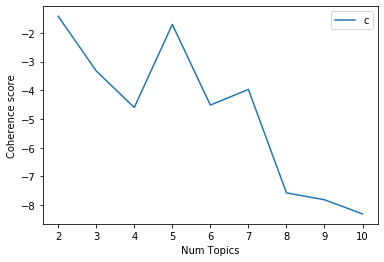

In [21]:
# Show umass graph
limit=11; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, umass_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

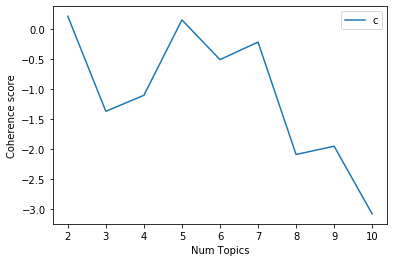

In [19]:
# Show uci graph
limit=11; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, uci_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

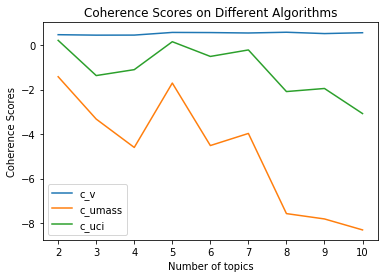

In [22]:
limit=11; start=2; step=1;
x = range(start, limit, step) # number of topics
y = [coherence_values, umass_values, uci_values]
plt.xlabel("Number of topics")
plt.ylabel("Coherence Scores")
plt.title("Coherence Scores on Different Algorithms")
label_name = ['c_v','c_umass', 'c_uci']
count = 0
for line in y:
    plt.plot(x, line, label = label_name[count])
    count += 1
# for i in range(len(y[0])):
#     plt.plot(x,[pt[i] for pt in y],label = 'id %s'%i)
plt.legend(loc='best')
plt.show()

In [17]:
# normalized
model_list[4].show_topics()

[(0,
  '0.003*"woman" + 0.002*"video" + 0.002*"like" + 0.002*"life" + 0.001*"love" + 0.001*"know" + 0.001*"film" + 0.001*"black" + 0.001*"family" + 0.001*"story"'),
 (1,
  '0.002*"vivid_edited" + 0.002*"love_snarkily" + 0.002*"dissect_episode" + 0.002*"panda" + 0.001*"ceremony_newsletter" + 0.001*"extra_hot" + 0.001*"dramatic_rose" + 0.001*"serve_juicy" + 0.001*"celeb_news" + 0.001*"go_bachelorette"'),
 (2,
  '0.010*"percent" + 0.005*"margin_error" + 0.005*"based_margin" + 0.004*"survey" + 0.003*"news_quiz" + 0.003*"model_based" + 0.002*"try_quiz" + 0.002*"assumption_wrong" + 0.002*"survey_error" + 0.002*"error_rest"'),
 (3,
  '0.008*"birther_repeatedly" + 0.008*"incites_political" + 0.008*"liar_rampant" + 0.008*"violence_serial" + 0.008*"entire_religion" + 0.008*"note_regularly" + 0.008*"pledged_ban" + 0.008*"racist_misogynist" + 0.004*"check_clip" + 0.003*"entering"'),
 (4,
  '0.002*"state" + 0.002*"election" + 0.002*"vote" + 0.002*"president" + 0.002*"government" + 0.002*"percent" +

In [18]:
def normalize(x):
    return np.tanh(x)

n_umass = normalize(umass_values)
n_uci = normalize(uci_values)
n_cv = normalize(coherence_values)

In [19]:
coherence_values
n_cv

array([0.43928512, 0.42259655, 0.42462198, 0.5177528 , 0.51305926,
       0.49883029, 0.52369614, 0.47877284, 0.50778022])

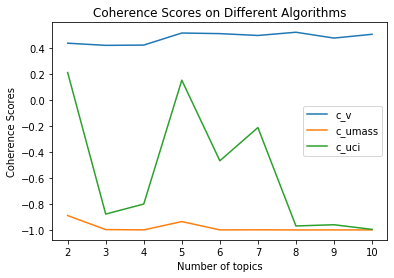

In [20]:
limit=11; start=2; step=1;
x = range(start, limit, step) # number of topics
y = [n_cv, n_umass, n_uci]
plt.xlabel("Number of topics")
plt.ylabel("Coherence Scores")
plt.title("Coherence Scores on Different Algorithms")
label_name = ['c_v','c_umass', 'c_uci']
count = 0
for line in y:
    plt.plot(x, line, label = label_name[count])
    count += 1
# for i in range(len(y[0])):
#     plt.plot(x,[pt[i] for pt in y],label = 'id %s'%i)
plt.legend(loc='best')
plt.show()

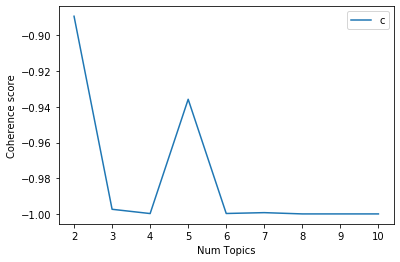

In [21]:
# Show n_umass graph
limit=11; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, n_umass)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("c_umass"), loc='best')
plt.show()

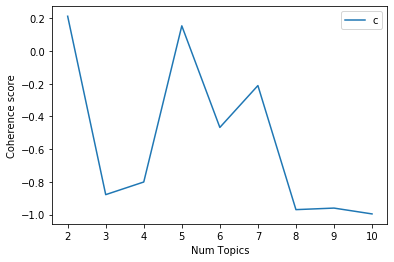

In [22]:
# Show n_uman_uciss graph
limit=11; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, n_uci)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("c_uci"), loc='best')
plt.show()

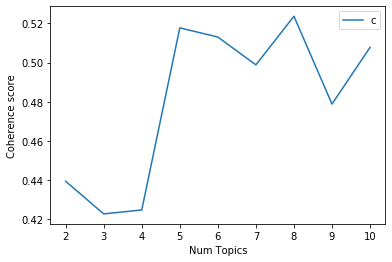

In [23]:
# Show c_v graph
limit=11; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, n_cv)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("c_v"), loc='best')
plt.show()

In [47]:
# 5 topics
start = time.time()
test_lda_model = pyLDAvis.gensim.prepare(model_list[3], corpus_tfidf2_bi, dictionary2_bi)
print("Processed time: " + str((time.time() - start)/60))
pyLDAvis.display(test_lda_model)

Processed time: 6.2671311895052595


# Normalize max min

In [24]:
def normalize_maxmin(x, min, max):
    return (x - min) / (max - min)
def get_normalized_array(arr):
    return [normalize_maxmin(n, min(arr), max(arr)) for n in arr]

In [25]:
# get number for cv
nmm_cv = get_normalized_array(n_cv)
nmm_cv

[0.1650706684967761,
 0.0,
 0.020034054084129796,
 0.9412130542498284,
 0.8947881228476572,
 0.7540459584222855,
 1.0,
 0.5556530298195158,
 0.8425718159398637]

In [26]:
# get number for umass
nmm_umass = get_normalized_array(n_umass)
nmm_umass

[1.0,
 0.02341761191423435,
 0.001828903226083461,
 0.579890619492433,
 0.002168587105543602,
 0.006445082457853972,
 3.6737756765281498e-06,
 1.852209109963694e-06,
 0.0]

In [27]:
# get number for uci
nmm_uci = get_normalized_array(n_uci)
nmm_uci

[1.0,
 0.0975107213938815,
 0.16148066350425613,
 0.9515020664021157,
 0.4375047063224335,
 0.6493114388849932,
 0.02163966928139993,
 0.02948298974698734,
 0.0]

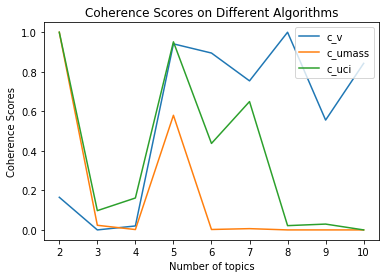

In [28]:
limit=11; start=2; step=1;
x = range(start, limit, step) # number of topics
y = [nmm_cv, nmm_umass, nmm_uci]
plt.xlabel("Number of topics")
plt.ylabel("Coherence Scores")
plt.title("Coherence Scores on Different Algorithms")
label_name = ['c_v','c_umass', 'c_uci']
count = 0
for line in y:
    plt.plot(x, line, label = label_name[count])
    count += 1
# for i in range(len(y[0])):
#     plt.plot(x,[pt[i] for pt in y],label = 'id %s'%i)
plt.legend(loc='best')
plt.show()

## Human Judgement

In [29]:
# maple
maple = [5, 5, 6, 8, 5, 7, 4, 2, 2]
# nick
nick = [5, 6, 7, 9, 6, 7, 5, 4, 4.5]
# alice
alice = [6, 7, 7.5, 9.8, 6, 7, 4, 3, 3]
# jason
jason = [6, 5.8, 6.2, 8.5, 5.4, 5.8, 4.2, 4, 4]
# professor
professor = [5, 5, 7, 8, 7, 8, 5, 5, 5]

In [30]:
n_maple = get_normalized_array(maple)
n_nick = get_normalized_array(nick)
n_alice = get_normalized_array(alice)
n_jason = get_normalized_array(jason)
n_professor = get_normalized_array(professor)

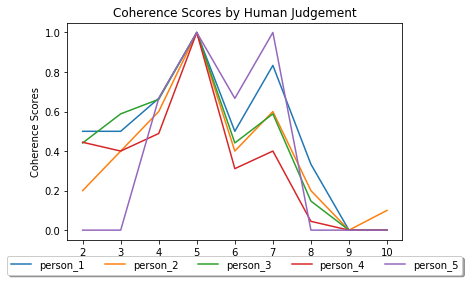

In [31]:
# only human judgement
limit=11; start=2; step=1;
x = range(start, limit, step) # number of topics
y = [n_maple, n_nick, n_alice, n_jason, n_professor]
plt.xlabel("Number of topics")
plt.ylabel("Coherence Scores")
plt.title("Coherence Scores by Human Judgement")
label_name = ['person_1','person_2', 'person_3', 'person_4', 'person_5']
count = 0
for line in y:
    plt.plot(x, line, label = label_name[count])
    count += 1
# for i in range(len(y[0])):
#     plt.plot(x,[pt[i] for pt in y],label = 'id %s'%i)
plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()

In [32]:
# avg of all human judgement
human_judge = []
human_judge.append(n_maple)
human_judge.append(n_nick)
human_judge.append(n_alice)
human_judge.append(n_jason)
human_judge.append(n_professor)

In [33]:
human_avg = []
for i in range(len(n_maple)):
    _sum = []
    for j in range(len(human_judge)):
        _sum.append(human_judge[j][i])
    human_avg.append(numpy.mean(_sum))
human_avg

[0.31712418300653594,
 0.3776470588235294,
 0.616797385620915,
 1.0,
 0.46379084967320255,
 0.6843137254901961,
 0.14496732026143794,
 0.0,
 0.02]

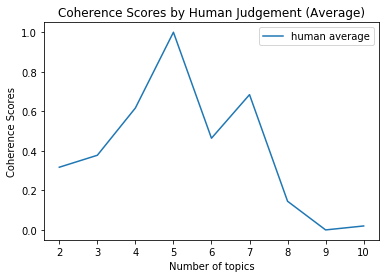

In [34]:
# avg human judgement
limit=11; start=2; step=1;
x = range(start, limit, step) # number of topics
y = [human_avg]
plt.xlabel("Number of topics")
plt.ylabel("Coherence Scores")
plt.title("Coherence Scores by Human Judgement (Average)")
label_name = ['human average']
count = 0
for line in y:
    plt.plot(x, line, label = label_name[count])
    count += 1
# for i in range(len(y[0])):
#     plt.plot(x,[pt[i] for pt in y],label = 'id %s'%i)
plt.legend(loc='best')
plt.show()

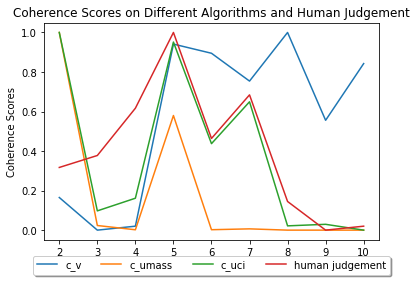

In [35]:
# combine human and machine
limit=11; start=2; step=1;
x = range(start, limit, step) # number of topics
y = [nmm_cv, nmm_umass, nmm_uci, human_avg]
plt.xlabel("Number of topics")
plt.ylabel("Coherence Scores")
plt.title("Coherence Scores on Different Algorithms and Human Judgement")
label_name = ['c_v','c_umass', 'c_uci', 'human judgement']
count = 0
for line in y:
    plt.plot(x, line, label = label_name[count])
    count += 1
# for i in range(len(y[0])):
#     plt.plot(x,[pt[i] for pt in y],label = 'id %s'%i)
plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()

# Kappa Value

In [36]:
# !pip install numpy krippendorff (Krippendorff's alpha)
import krippendorff
kappa = krippendorff.alpha(human_judge)
print(kappa) 

0.8153500302080882


In [61]:
# avg of all automated metrics
avg_metrics = []
for i in range(len(nmm_cv)):
    avg_metrics.append((nmm_cv[i] + nmm_umass[i] + nmm_uci[i])/3)
avg_metrics

[0.7216902228322587,
 0.040309444436038615,
 0.0611145402714898,
 0.824201913381459,
 0.4448204720918781,
 0.4699341599217109,
 0.34054778101902555,
 0.1950459572585377,
 0.2808572719799546]

In [62]:
# avg human judgement
avg_human = []
for i in range(len(human_judge[0])):
    avg_human.append((human_judge[0][i] + human_judge[1][i] + human_judge[2][i] + human_judge[3][i] + human_judge[4][i])/5)
avg_human

[0.31712418300653594,
 0.3776470588235294,
 0.616797385620915,
 1.0,
 0.46379084967320255,
 0.6843137254901961,
 0.14496732026143794,
 0.0,
 0.02]

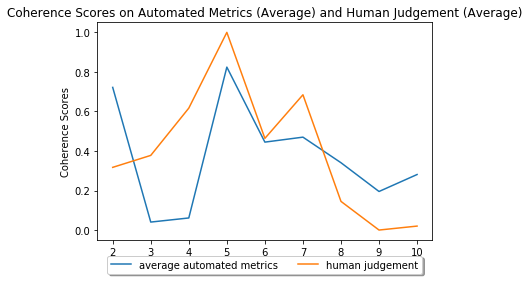

In [76]:
# combine human and machine
limit=11; start=2; step=1;
x = range(start, limit, step) # number of topics
y = [avg_metrics, human_avg]
plt.xlabel("Number of topics")
plt.ylabel("Coherence Scores")
plt.title("Coherence Scores on Automated Metrics (Average) and Human Judgement (Average)")
label_name = ['average automated metrics', 'human judgement']
count = 0
for line in y:
    plt.plot(x, line, label = label_name[count])
    count += 1
# for i in range(len(y[0])):
#     plt.plot(x,[pt[i] for pt in y],label = 'id %s'%i)
plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()

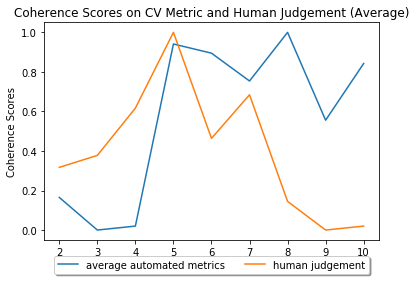

In [77]:
# combine human and machine
limit=11; start=2; step=1;
x = range(start, limit, step) # number of topics
y = [nmm_cv, human_avg]
plt.xlabel("Number of topics")
plt.ylabel("Coherence Scores")
plt.title("Coherence Scores on CV Metric and Human Judgement (Average)")
label_name = ['average automated metrics', 'human judgement']
count = 0
for line in y:
    plt.plot(x, line, label = label_name[count])
    count += 1
# for i in range(len(y[0])):
#     plt.plot(x,[pt[i] for pt in y],label = 'id %s'%i)
plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()

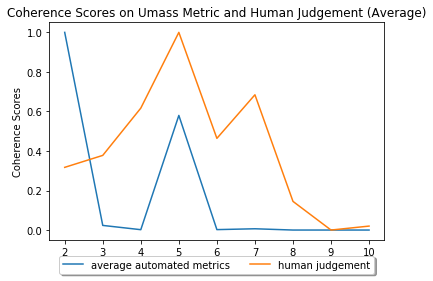

In [78]:
# combine human and machine
limit=11; start=2; step=1;
x = range(start, limit, step) # number of topics
y = [nmm_umass, human_avg]
plt.xlabel("Number of topics")
plt.ylabel("Coherence Scores")
plt.title("Coherence Scores on Umass Metric and Human Judgement (Average)")
label_name = ['average automated metrics', 'human judgement']
count = 0
for line in y:
    plt.plot(x, line, label = label_name[count])
    count += 1
# for i in range(len(y[0])):
#     plt.plot(x,[pt[i] for pt in y],label = 'id %s'%i)
plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()

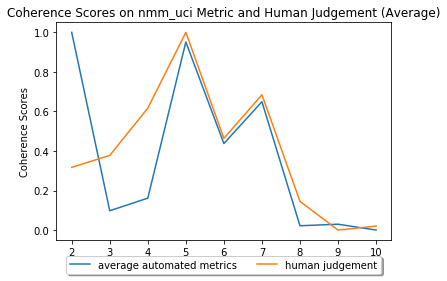

In [79]:
# combine human and machine
limit=11; start=2; step=1;
x = range(start, limit, step) # number of topics
y = [nmm_uci, human_avg]
plt.xlabel("Number of topics")
plt.ylabel("Coherence Scores")
plt.title("Coherence Scores on nmm_uci Metric and Human Judgement (Average)")
label_name = ['average automated metrics', 'human judgement']
count = 0
for line in y:
    plt.plot(x, line, label = label_name[count])
    count += 1
# for i in range(len(y[0])):
#     plt.plot(x,[pt[i] for pt in y],label = 'id %s'%i)
plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()

In [63]:
# avg metrics and avg human judge
kappa = krippendorff.alpha([avg_metrics,avg_human])
print(kappa) 

0.4777426252528113


In [64]:
# cv and avg human judge
kappa = krippendorff.alpha([nmm_cv,avg_human])
print(kappa) 

0.013873655116605543


In [65]:
# umass and avg human judge
kappa = krippendorff.alpha([nmm_umass,avg_human])
print(kappa) 

0.18804433248569286


In [66]:
# uci and avg human judge
kappa = krippendorff.alpha([nmm_uci,avg_human])
print(kappa) 

0.6655428667577818


# Number of document per topic

In [37]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=model_list[3], corpus=corpus_tfidf2_bi, texts=transcript2)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()


# Show
df_dominant_topic.head(10)

,index,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
0,0,4.0,0.7226,"film, woman, video, love, star, movie, like, f...",sat at the kitchen table in an unfamiliar apar...
1,1,4.0,0.7959,"film, woman, video, love, star, movie, like, f...",the starts in and now it has an official song ...
2,2,4.0,0.8801,"film, woman, video, love, star, movie, like, f...",actually turned to matrimony for the year old ...
3,3,4.0,0.6512,"film, woman, video, love, star, movie, like, f...",calif and fellow better grow pair in battling ...
4,4,4.0,0.8533,"film, woman, video, love, star, movie, like, f...",unleashed her funny method of venting at on th...
5,5,4.0,0.4815,"film, woman, video, love, star, movie, like, f...",spoke out again in the wake of sexual harassme...
6,6,4.0,0.8252,"film, woman, video, love, star, movie, like, f...",fast food loving can get his mind off mc new b...
7,7,4.0,0.8320,"film, woman, video, love, star, movie, like, f...",is currently starring with in the film termina...
8,8,4.0,0.8982,"film, woman, video, love, star, movie, like, f...",recommends as the movie you should watch on th...
9,9,4.0,0.5750,"film, woman, video, love, star, movie, like, f...",paid visit to victims of last week school shoo...


In [38]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8596,"investigation, email, intelligence, informatio...",director affirmed on that the special counsel ...
1,1.0,0.9655,"company, percent, health_care, tax, million, c...",cross posted from mong the stranger features o...
2,2.0,0.9659,"election, president, state, country, vote, cam...",says hates us chief strategist and now top fig...
3,3.0,0.5634,"percent, marijuana, margin_error, based_margin...",most are standing by the decisions they made o...
4,4.0,0.9535,"film, woman, video, love, star, movie, like, f...",hi it i heard when picked up the phone afterno...


In [39]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head()

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,4.0,"film, woman, video, love, star, movie, like, f...",270.0,0.0077
1.0,4.0,"film, woman, video, love, star, movie, like, f...",7754.0,0.2212
2.0,4.0,"film, woman, video, love, star, movie, like, f...",15826.0,0.4514
3.0,4.0,"film, woman, video, love, star, movie, like, f...",21.0,0.0006
4.0,4.0,"film, woman, video, love, star, movie, like, f...",11185.0,0.3191


In [40]:
topic_counts
# 0 = investi
# 1 = company
# 2 = election
# 3 = percent, marijuana
# 4 = film

2.0    15826
4.0    11185
1.0     7754
0.0      270
3.0       21
Name: Dominant_Topic, dtype: int64

In [41]:
df_dominant_topics[df_dominant_topics['Dominant_Topic'] == 0.0]['Topic_Keywords'].unique().tolist()

['investigation, email, intelligence, information, probe, campaign, special_counsel, committee, hacking, document']

In [42]:
df_dominant_topics[df_dominant_topics['Dominant_Topic'] == 1.0]['Topic_Keywords'].unique().tolist()

['company, percent, health_care, tax, million, climate_change, state, school, plan, woman']

In [43]:
df_dominant_topics[df_dominant_topics['Dominant_Topic'] == 2.0]['Topic_Keywords'].unique().tolist()

['election, president, state, country, vote, campaign, police, government, attack, official']

In [44]:
df_dominant_topics[df_dominant_topics['Dominant_Topic'] == 3.0]['Topic_Keywords'].unique().tolist()

['percent, marijuana, margin_error, based_margin, survey, cannabis, model_based, assumption_wrong, survey_error, error_rest']

In [45]:
df_dominant_topics[df_dominant_topics['Dominant_Topic'] == 4.0]['Topic_Keywords'].unique().tolist()

['film, woman, video, love, star, movie, like, fan, host, actor']

In [46]:
doc_counts = topic_counts.reset_index()
doc_counts.columns = ['Topic_num', 'Doc_counts']
doc_counts = doc_counts.astype(int)
doc_counts

,Topic_num,Doc_counts
0,2,15826
1,4,11185
2,1,7754
3,0,270
4,3,21


In [ ]:
# Topic_2 = 15818 docs (['election, president, state, country, vote, campaign, police, government, attack, official'])
# Topic_4 = 11188 docs (['film, woman, video, love, star, movie, like, fan, host, actor'])
# Topic_1 = 7758 docs (['company, percent, health_care, tax, million, climate_change, state, school, plan, woman'])
# Topic_0 = 271 docs (['investigation, email, intelligence, information, probe, campaign, special_counsel, committee, hacking, document'])
# Topic_3= 21 docs (['percent, marijuana, margin_error, based_margin, survey, cannabis, model_based, assumption_wrong, survey_error, error_rest'])